This notebook was created as a compilation of the coding project described in detail at https://dataforpublichealth.com/post-details/mental-health-mlr-one-hot-encoding-brfss. As described in that post, the base data is available at https://dataforpublichealth.com/post-details/wrangling-brfss-2011-2023.

In [91]:
# Load libraries for entire project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

In [111]:
# Load data (available at https://dataforpublichealth.com/post-details/wrangling-brfss-2011-2023)
data = pd.read_csv('data/2023_350.csv', low_memory=False)

In [112]:
# Exclude rows of dependent variable (MENTHLTH) with missing values, 99, and 77
data = data[data['MENTHLTH'] != '77']
data = data[data['MENTHLTH'] != '99']
data = data.dropna(subset=['MENTHLTH'])

In [113]:
# Replace empty strings, spaces, or other patterns with NaN
data.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# Count missing values per column
missing_summary = data.isnull().sum().sort_values(ascending=False)
missing_summary = missing_summary[missing_summary > 0]  # Only show columns with missing values
missing_summary = pd.DataFrame({'Missing Values': missing_summary, 
                                'Percentage': (missing_summary / len(data)) * 100})
print(missing_summary)

C:\Users\unkno\AppData\Local\Temp\ipykernel_17844\397828159.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace(r'^\s*$', np.nan, regex=True, inplace=True)


          Missing Values  Percentage
NUMBURN3          425218  100.000000
WKDAYOUT          425218  100.000000
INDORTAN          425218  100.000000
SUNPRTCT          425218  100.000000
WKENDOUT          425218  100.000000
...                  ...         ...
ADDEPEV3               3    0.000706
CVDINFR4               3    0.000706
CHECKUP1               2    0.000470
MEDCOST1               2    0.000470
EXERANY2               2    0.000470

[287 rows x 2 columns]


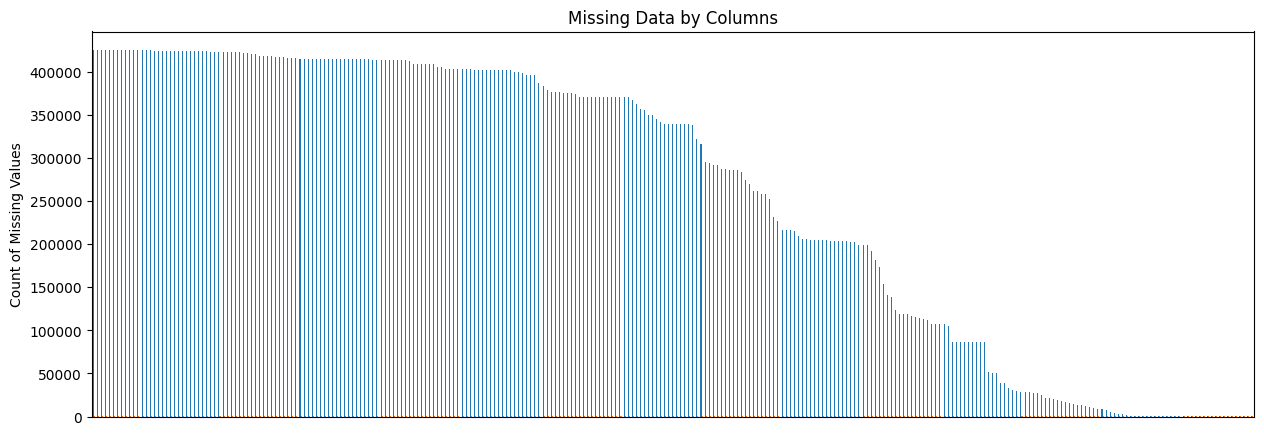

In [114]:
# Count missing data per column and plot
missing_summary.plot(kind='bar', figsize=(15, 5), legend=False)
plt.title("Missing Data by Columns")
plt.ylabel("Count of Missing Values")
plt.xticks([])
plt.show()

In [115]:
## Set a threshold for allowable missing values and exclude columns 
## with more than the threshold

# Set the threshold percentage
threshold = 25 / 100  # 25% as a fraction

# Calculate the percentage of missing values per column
missing_percentage = data.isnull().mean()

# Filter columns: Keep only those with less than or equal to 25% missing data
columns_to_keep = missing_percentage[missing_percentage <= threshold].index

# Create a new DataFrame with the filtered columns
data_filtered = data[columns_to_keep]

# Output
print(f"Original shape: {data.shape}")
print(f"Filtered shape (after excluding >25% missing): {data_filtered.shape}")


Original shape: (425218, 350)
Filtered shape (after excluding >25% missing): (425218, 139)


In [116]:
# Drop non-informative columns
data_filtered = data_filtered.drop(['FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE', 
                                    'SEQNO', 'x_PSU', 'SAFETIME', 'CTELNUM1', 'CELLFON5', 'CADULT1', 
                                    'CELLSEX2', 'CSTATE1', 'LANDLINE', 'x_STSTR', 'x_STRWT', 
                                    'x_WT2RAKE', 'x_LLCPWT2', 'x_LLCPWT', 'QSTVER', 'QSTLANG',
                                    'x_RAWRAKE', 'x_DUALUSE', ], axis=1)

# Drop height/weight columns (used to calculate BMI, which is retained)
data_filtered = data_filtered.drop(['WEIGHT2', 'HEIGHT3', 'HTIN4', 'WTKG3'], axis=1)

# Drop ALCDAY4 (used to calculate other retained variables on alcohol consumption)
data_filtered = data_filtered.drop(['ALCDAY4'], axis=1)

# Output
print(f"Shape after dropping non-informative columns: {data_filtered.shape}")

Shape after dropping non-informative columns: (425218, 110)


In [117]:
# Drop all rows with missing values
data_filtered = data_filtered.dropna()

print(f"Shape after dropping rows with missing values: {data_filtered.shape}")

Shape after dropping rows with missing values: (189279, 110)


In [118]:
# Cast all columns as numeric
data_filtered = data_filtered.apply(pd.to_numeric, errors='coerce')

## Recode 88 in MENTHLTH, PHYSHLTH, POORHLTH, CHILDREN, & SMOKE100 to 0
data_filtered['MENTHLTH'] = data_filtered['MENTHLTH'].replace(88, 0)
data_filtered['PHYSHLTH'] = data_filtered['PHYSHLTH'].replace(88, 0)
data_filtered['CHILDREN'] = data_filtered['CHILDREN'].replace(88, 0)
data_filtered['SMOKE100'] = data_filtered['SMOKE100'].replace(88, 0)

# Remove records where PHYSHLTH, POORHLTH, HHADULT, CHILDREN, or SMOKE100 is 77 or 99
data_filtered = data_filtered[~data_filtered['PHYSHLTH'].isin([77, 99])]
data_filtered = data_filtered[~data_filtered['HHADULT'].isin([77, 99])]
data_filtered = data_filtered[~data_filtered['CHILDREN'].isin([77, 99])]
data_filtered = data_filtered[~data_filtered['SMOKE100'].isin([77, 99])]

# Remove records where MAXVO21_, FC601_, or x_DRNKWK2 is 99900
data_filtered = data_filtered[~data_filtered['MAXVO21_'].isin([99900])]
data_filtered = data_filtered[~data_filtered['FC601_'].isin([99900])]
data_filtered = data_filtered[~data_filtered['x_DRNKWK2'].isin([99900])]

# Remove records where STRFREQ_ is '99000'
data_filtered = data_filtered[~data_filtered['STRFREQ_'].isin([99000])]

# Remove records where DROCDY4_ is 900
data_filtered = data_filtered[~data_filtered['DROCDY4_'].isin([900])]

# Print the shape of the data after removing records
print(f"Shape after removing records: {data_filtered.shape}")

Shape after removing records: (182061, 110)


In [119]:
## Confirm that the values have been removed

# Print lowest and highest values in MENTHLTH, PHYSHLTH, CHILDREN, SMOKE100, HHADULT, MAXVO21_, FC601_, x_DRNKWK2, STRFREQ_, DROCDY4_
print(f"MENTHLTH: {data_filtered['MENTHLTH'].min()} - {data_filtered['MENTHLTH'].max()}")
print(f"PHYSHLTH: {data_filtered['PHYSHLTH'].min()} - {data_filtered['PHYSHLTH'].max()}")
print(f"CHILDREN: {data_filtered['CHILDREN'].min()} - {data_filtered['CHILDREN'].max()}")
print(f"SMOKE100: {data_filtered['SMOKE100'].min()} - {data_filtered['SMOKE100'].max()}")
print(f"HHADULT: {data_filtered['HHADULT'].min()} - {data_filtered['HHADULT'].max()}")
print(f"MAXVO21_: {data_filtered['MAXVO21_'].min()} - {data_filtered['MAXVO21_'].max()}")
print(f"FC601_: {data_filtered['FC601_'].min()} - {data_filtered['FC601_'].max()}")
print(f"x_DRNKWK2: {data_filtered['x_DRNKWK2'].min()} - {data_filtered['x_DRNKWK2'].max()}")
print(f"STRFREQ_: {data_filtered['STRFREQ_'].min()} - {data_filtered['STRFREQ_'].max()}")
print(f"DROCDY4_: {data_filtered['DROCDY4_'].min()} - {data_filtered['DROCDY4_'].max()}")

MENTHLTH: 0 - 30
PHYSHLTH: 0 - 30
CHILDREN: 0 - 81
SMOKE100: 1 - 9
HHADULT: 1 - 52
MAXVO21_: 555 - 5010
FC601_: 95 - 859
x_DRNKWK2: 0 - 53200
STRFREQ_: 0 - 95000
DROCDY4_: 0 - 100


In [120]:
# Perform iterative correlation testing to determine which columns to keep

# Step 1: Compute correlation matrix for continuous predictors
continuous_vars = ['MAXVO21_', 'FC601_', 'x_BMI5', 'DROCDY4_', 'x_DRNKWK2', 'PHYSHLTH', 'CHILDREN', 'HHADULT', 'STRFREQ_']
categorical_vars = [col for col in data_filtered.columns if col not in continuous_vars] # For Cramer's V (next)

# Remove dependent variable MENTHLTH from list (not categorical, not predictor)
categorical_vars.remove('MENTHLTH')

corr_matrix = data_filtered[continuous_vars].corr().abs()  # Absolute correlations

# Step 2: Remove duplicate correlations (upper triangle)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 3: Identify predictors to drop based on threshold
threshold = 0.7  # Set correlation threshold to avoid high redundancy
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

print(f"Columns to drop due to high correlation: {to_drop}")

Columns to drop due to high correlation: ['FC601_']


In [121]:
# Print number of columns before removal
print(f"Columns before removal: {data_filtered.shape[1]}")

# Remove the columns identified above
data_filtered = data_filtered.drop(to_drop, axis=1)

# Remove dropped variables from lists
continuous_vars = [col for col in continuous_vars if col not in to_drop]

# Print number of columns after removal
print(f"Columns after removal: {data_filtered.shape[1]}")

Columns before removal: 110
Columns after removal: 109


In [122]:
# Remove x_MENT14D from data_filtered
data_filtered = data_filtered.drop('x_MENT14D', axis=1)

# Remove x_MENT14D from categorical_vars
categorical_vars = [col for col in categorical_vars if col != 'x_MENT14D']

In [123]:

# Function to compute Cramér's V
def cramers_v(x, y):
    """Calculate Cramér's V for two categorical variables."""
    confusion_matrix = pd.crosstab(x, y)  # Create a contingency table
    chi2, _, _, _ = chi2_contingency(confusion_matrix)  # Perform Chi-Square test
    n = confusion_matrix.sum().sum()  # Total number of observations
    phi2 = chi2 / n  # Compute phi-squared
    r, k = confusion_matrix.shape  # Number of rows and columns in the table
    phi2_corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))  # Bias correction
    r_corr = max(1, r - ((r-1)**2) / (n-1))  # Ensure corrected rows > 0
    k_corr = max(1, k - ((k-1)**2) / (n-1))  # Ensure corrected columns > 0
    denominator = min((k_corr - 1), (r_corr - 1))
    if denominator <= 0:  # Avoid division by zero
        return np.nan
    return np.sqrt(phi2_corr / denominator)  # Return Cramér's V

# Create a matrix to store Cramér's V values
cramers_matrix = pd.DataFrame(index=categorical_vars, columns=categorical_vars)

# Compute Cramér's V for all pairs of categorical variables
for col1 in categorical_vars:
    for col2 in categorical_vars:
        if col1 == col2:
            cramers_matrix.loc[col1, col2] = 0.0  # Self-correlation set to 0 for comparison
        else:
            cramers_matrix.loc[col1, col2] = cramers_v(data_filtered[col1], data_filtered[col2])

# Convert matrix values to floats for further processing
cramers_matrix = cramers_matrix.astype(float)

# Print Cramér's V matrix
print("Cramér's V Matrix:")
print(cramers_matrix)

# Identify variables with high association (e.g., V > 0.8)
threshold = 0.7  # Set threshold for high association
to_drop_cat = []

# Iterate over columns and ignore self-correlation (diagonal values)
for col in cramers_matrix.columns:
    high_association = cramers_matrix[col][cramers_matrix.index != col] > threshold  # Exclude diagonal
    if any(high_association):
        to_drop_cat.append(col)

print(f"Categorical variables to drop (V > {threshold}): {to_drop_cat}")


Cramér's V Matrix:
            x_STATE  PVTRESD3    SEXVAR   GENHLTH  PRIMINS1  PERSDOC3  \
x_STATE    0.000000  0.019688  0.037404  0.034432  0.074340  0.074993   
PVTRESD3   0.019688  0.000000  0.001820  0.005247  0.072748  0.028740   
SEXVAR     0.037404  0.001820  0.000000  0.023746  0.106490  0.105103   
GENHLTH    0.034432  0.005247  0.023746  0.000000  0.085175  0.057694   
PRIMINS1   0.074340  0.072748  0.106490  0.085175  0.000000  0.164004   
...             ...       ...       ...       ...       ...       ...   
x_RFDRHV8  0.039796  0.000000  0.028560  0.019516  0.030376  0.023418   
x_AIDTST4  0.096365  0.011520  0.017422  0.040151  0.155930  0.037157   
x_RFSEAT2  0.068232  0.006226  0.071492  0.046004  0.047748  0.038755   
x_RFSEAT3  0.104403  0.009937  0.087763  0.048683  0.050152  0.045072   
x_DRNKDRV  0.105457  0.015801  0.072932  0.108287  0.113024  0.014821   

           MEDCOST1  CHECKUP1  EXERANY2  EXRACT12  ...  x_SMOKER3  x_RFSMOK3  \
x_STATE    0.037557  0.0

In [124]:
# Remove the categorical variables identified above with Cramer's V
data_filtered = data_filtered.drop(to_drop_cat, axis=1)

# Remove to_drop_cat from categorical_vars
categorical_vars = [col for col in categorical_vars if col not in to_drop_cat]

# print the shape of the data after removing columns
print(f"Shape after removing columns: {data_filtered.shape}")

Shape after removing columns: (182061, 45)


In [ ]:
# Print columns
print(data_filtered.columns)

Index(['x_STATE', 'PVTRESD3', 'HHADULT', 'PHYSHLTH', 'MENTHLTH', 'PERSDOC3',
       'MEDCOST1', 'CHECKUP1', 'EXERANY2', 'EXRACT12', 'CHOLMED3', 'CVDSTRK3',
       'CHCSCNC1', 'CHCOCNC1', 'CHCCOPD3', 'ADDEPEV3', 'CHCKDNY2', 'DIABETE4',
       'MARITAL', 'RENTHOM1', 'CPDEMO1C', 'VETERAN3', 'CHILDREN', 'DEAF',
       'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'USENOW3',
       'FLUSHOT7', 'PNEUVAC4', 'COVIDPO1', 'x_METSTAT', 'x_URBSTAT',
       'x_PHYS14D', 'x_TOTINDA', 'MAXVO21_', 'STRFREQ_', 'x_BMI5', 'x_CHLDCNT',
       'DROCDY4_', 'x_RFBING6', 'x_DRNKWK2', 'x_RFDRHV8'],
      dtype='object')


C:\Users\unkno\AppData\Local\Temp\ipykernel_17844\710325749.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data_filtered = data_filtered.apply(pd.to_numeric, errors='ignore')


In [125]:
# Quick Bivariate Analyses to further narrow down predictors
# Target column in data_filtered
target_col = 'MENTHLTH'

# Compute correlations for continuous variables
correlations = {}
for col in continuous_vars:
    try:
        # Compute correlation between the continuous variable and the target
        correlations[col] = data_filtered[target_col].corr(data_filtered[col])
    except Exception as e:
        print(f"Error with variable {col}: {e}")

# Filter predictors based on correlation threshold
threshold = 0.2
selected_continuous = [col for col, corr in correlations.items() if abs(corr) > threshold]

print("Selected Continuous Variables:", selected_continuous)


Selected Continuous Variables: ['PHYSHLTH']


In [126]:
# Target column in data_filtered
target_col = 'MENTHLTH'

# Perform ANOVA for each categorical variable
anova_results = {}
for col in categorical_vars:  # Ensure categorical_vars contains original column names
    try:
        # Group the target variable (MENTHLTH) by each level of the categorical variable
        groups = [
            data_filtered.loc[data_filtered[col] == level, target_col]  # Subset target by category levels
            for level in data_filtered[col].dropna().unique()
        ]
        if len(groups) > 1:  # Ensure at least two groups exist
            anova_results[col] = f_oneway(*groups).pvalue
    except KeyError:
        print(f"Variable {col} is not in data_filtered and was skipped.")
    except Exception as e:
        print(f"Error with variable {col}: {e}")

# Filter categorical predictors based on p-value threshold
pval_threshold = 0.05
selected_categorical = [col for col, pval in anova_results.items() if pval < pval_threshold]

print("Selected Categorical Variables:", selected_categorical)


Selected Categorical Variables: ['x_STATE', 'PVTRESD3', 'PERSDOC3', 'MEDCOST1', 'CHECKUP1', 'EXRACT12', 'CHOLMED3', 'CVDSTRK3', 'CHCSCNC1', 'CHCOCNC1', 'CHCCOPD3', 'ADDEPEV3', 'CHCKDNY2', 'DIABETE4', 'MARITAL', 'RENTHOM1', 'CPDEMO1C', 'VETERAN3', 'DEAF', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'USENOW3', 'FLUSHOT7', 'PNEUVAC4', 'COVIDPO1', 'x_METSTAT', 'x_URBSTAT', 'x_PHYS14D', 'x_CHLDCNT', 'x_RFBING6', 'x_RFDRHV8']


In [128]:
# Print number of selected_categorical variables
print(f"Number of selected categorical variables: {len(selected_categorical)}")

Number of selected categorical variables: 34


In [129]:
# Combine selected predictors
selected_predictors = selected_continuous + selected_categorical

# Ensure all selected predictors exist in data_filtered
selected_predictors = [col for col in selected_predictors if col in data_filtered.columns]

# Add the target variable to the list
selected_predictors.append(target_col)

# Create the reduced dataset
data_prepared = data_filtered[selected_predictors]

In [131]:
# Print the shape of the reduced dataset
print(f"Shape of the reduced dataset: {data_prepared.shape}")

Shape of the reduced dataset: (182061, 36)


In [132]:
## One-Hot Encoding

# Step 1: Break data into target and predictors
y = data_prepared['MENTHLTH']
X = data_prepared.drop(columns=['MENTHLTH'])

# Step 2: One-Hot Encode Remaining Categorical Variables
X_encoded = pd.get_dummies(X, columns=selected_categorical, drop_first=True)

# Step 3: Convert all encoded columns to integers (0/1)
X_encoded = X_encoded.astype(int)

# Step 4: Combine Continuous and Encoded Variables
# Ensure all continuous variables remain intact
X_final = X_encoded[selected_continuous].join(X_encoded.drop(columns=selected_continuous, errors='ignore'))

# Step 5: Verify Final Data
print("Final Predictor Variables:")
print(X_final.head())
print("Shape:", X_final.shape)


Final Predictor Variables:
     PHYSHLTH  x_STATE_2  x_STATE_4  x_STATE_5  x_STATE_6  x_STATE_8  \
961         0          0          0          0          0          0   
962         0          0          0          0          0          0   
963         1          0          0          0          0          0   
966         5          0          0          0          0          0   
967         4          0          0          0          0          0   

     x_STATE_9  x_STATE_10  x_STATE_11  x_STATE_12  ...  x_PHYS14D_2  \
961          0           0           0           0  ...            0   
962          0           0           0           0  ...            0   
963          0           0           0           0  ...            1   
966          0           0           0           0  ...            1   
967          0           0           0           0  ...            1   

     x_PHYS14D_3  x_CHLDCNT_2  x_CHLDCNT_3  x_CHLDCNT_4  x_CHLDCNT_5  \
961            0            0      

In [133]:
# Step 1: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Step 2: Define Stepwise Selection Function
def stepwise_selection(X, y, threshold_in=0.05, threshold_out=0.05, verbose=True):
    """Perform stepwise selection to find the best predictors for the MLR model."""
    initial_list = []
    included = list(initial_list)
    while True:
        changed = False
        
        # Forward step: Add variable with the lowest p-value
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            try:
                model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
                new_pval[new_column] = model.pvalues[new_column]
            except Exception as e:
                print(f"Error with variable {new_column}: {e}")
                new_pval[new_column] = np.nan
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f"Adding {best_feature} with p-value {best_pval}")

        # Backward step: Remove variable with the highest p-value
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]  # Exclude intercept
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True
            if verbose:
                print(f"Dropping {worst_feature} with p-value {worst_pval}")

        if not changed:
            break

    return included


# Step 3: Run Stepwise Selection
selected_features = stepwise_selection(X_train, y_train)


Adding MEDCOST1_2 with p-value 0.0
Adding RENTHOM1_2 with p-value 0.0
Adding ADDEPEV3_2 with p-value 0.0
Adding x_PHYS14D_3 with p-value 0.0
Adding DECIDE_2 with p-value 0.0
Adding PHYSHLTH with p-value 1.9806015710709197e-288
Adding DIFFALON_2 with p-value 6.67802522511354e-184
Adding CHOLMED3_2 with p-value 6.281940620237544e-173
Adding MARITAL_5 with p-value 7.8937504939008e-137
Adding x_RFBING6_2 with p-value 3.286999987929458e-80
Adding x_PHYS14D_2 with p-value 3.91700052715059e-45
Adding MARITAL_6 with p-value 7.887667923004102e-32
Adding x_CHLDCNT_3 with p-value 3.325636429713605e-33
Adding x_CHLDCNT_2 with p-value 2.875501023207889e-37
Adding RENTHOM1_3 with p-value 2.0201546947404618e-24
Adding x_RFDRHV8_2 with p-value 2.715866407117292e-23
Adding DIFFWALK_2 with p-value 6.046174961076206e-21
Adding MARITAL_4 with p-value 8.15688610235675e-18
Adding FLUSHOT7_2 with p-value 1.0668585795251601e-16
Adding DECIDE_7 with p-value 3.605939686704826e-15
Adding CHCSCNC1_2 with p-value 

In [134]:
# count number of selected features
print(f"Number of selected features: {len(selected_features)}")

# save selected features as a .csv
selected_features_df = pd.DataFrame(selected_features, columns=['selected_features'])
selected_features_df.to_csv('data/selected_features.csv', index=False)

Number of selected features: 67


In [51]:
# Print selected features
print("Selected Features:")
print(selected_features)

Selected Features:
['CHOLMED3_2', 'MEDCOST1_2', 'RENTHOM1_2', 'ADDEPEV3_2', 'MAXVO21_', 'PHYSHLTH', 'DECIDE_2', 'x_RFBING6_2', 'PERSDOC3_2', 'VETERAN3_2', 'FLUSHOT7_2', 'COVIDPO1_2', 'USENOW3_3', 'x_METSTAT_2', 'EXRACT12_11', 'PNEUVAC4_7', 'EXRACT12_2', 'MARITAL_6', 'MARITAL_5', 'MARITAL_2', 'x_CHLDCNT_3', 'MARITAL_3', 'x_CHLDCNT_2', 'EXRACT12_10', 'x_STATE_53', 'DIABETE4_2', 'MARITAL_4', 'CHECKUP1_2', 'EXRACT12_9', 'x_STATE_45', 'x_RFDRHV8_2', 'PERSDOC3_3', 'DIABETE4_3', 'COVIDPO1_9', 'x_STATE_8', 'PERSDOC3_7', 'CHECKUP1_3', 'EXRACT12_77', 'x_STATE_38', 'x_STATE_20', 'DIFFWALK_2', 'PVTRESD3_2', 'USENOW3_2', 'x_PHYS14D_9', 'CPDEMO1C_9', 'x_STATE_41', 'CHECKUP1_7', 'x_CHLDCNT_4', 'x_STATE_25', 'COVIDPO1_7', 'CPDEMO1C_6', 'x_STATE_48', 'EXRACT12_4', 'MEDCOST1_7', 'CHECKUP1_8', 'PNEUVAC4_2', 'EXRACT12_5', 'x_STATE_29', 'CHECKUP1_4', 'ADDEPEV3_9', 'x_STATE_49', 'x_STATE_27', 'x_STATE_30', 'x_STATE_19']


In [135]:
# Step 4: Build Final Model with Selected Features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

final_model = sm.OLS(y_train, sm.add_constant(X_train_selected)).fit()
print("\nFinal Model Summary:")
print(final_model.summary())

# Step 5: Test the Model on the Test Set
y_pred = final_model.predict(sm.add_constant(X_test_selected))
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred.round())
print(f"Accuracy of the model on test set: {accuracy * 100:.2f}%")
print(f"\nMean Squared Error: {mse}\nR-squared: {r2}")


Final Model Summary:
                            OLS Regression Results                            
Dep. Variable:               MENTHLTH   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     924.5
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        13:49:30   Log-Likelihood:            -4.7477e+05
No. Observations:              145648   AIC:                         9.497e+05
Df Residuals:                  145580   BIC:                         9.503e+05
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          14.1739      

In [136]:
# Print top 10 coefficients
print("\nTop 10 Coefficients:")
print(final_model.params.sort_values(ascending=False).head(10))


Top 10 Coefficients:
const          14.173888
CHCSCNC1_9      4.146207
PVTRESD3_2      1.461692
MARITAL_5       1.291814
MARITAL_4       1.201567
x_CHLDCNT_5     1.018364
MARITAL_6       1.009169
MARITAL_9       1.008658
x_CHLDCNT_6     0.863935
CHCKDNY2_7      0.829080
dtype: float64


In [142]:
# Define a function to bin y, train an MLR model, and compute metrics
def run_mlr_with_bins(X, y, num_bins_list):
    results = []  # To store model metrics

    for num_bins in num_bins_list:
        # Bin the target variable
        if num_bins == 2:  # Special case for binary (0 vs. 1+)
            y_binned = (y > 0).astype(int)
        else:
            y_binned = pd.cut(y, bins=num_bins, labels=range(num_bins), include_lowest=True).astype(int)

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y_binned, test_size=0.2, random_state=42)

        # Train a multiple linear regression model
        X_train = sm.add_constant(X_train)  # Add constant for intercept
        X_test = sm.add_constant(X_test)    # Add constant for intercept

        model = sm.OLS(y_train, X_train).fit()

        # Test the model
        y_pred = model.predict(X_test)

        # Convert predictions to nearest integer bin
        y_pred_binned = np.rint(y_pred).astype(int)  # Round to nearest bin and convert to integers

        # Calculate performance metrics
        mse = mean_squared_error(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred_binned)

        # Store the results
        results.append({
            'Bins': num_bins,
            'MSE': mse,
            'Accuracy (%)': f"{accuracy * 100:.2f}%"
        })

    # Convert results to a DataFrame for a clean table
    results_df = pd.DataFrame(results)
    return results_df

# Run the function on your dataset
num_bins_list = [2, 3, 4, 5, 6]  # Define the binning segments
X = X_final  # Predictor variables
results_table = run_mlr_with_bins(X, y, num_bins_list)

# Display the results
print("Model Metrics for Different Binnings (MLR):")
print(results_table)


Model Metrics for Different Binnings (MLR):
   Bins       MSE Accuracy (%)
0     2  0.184873       73.16%
1     3  0.197644       85.34%
2     4  0.435013       75.23%
3     5  0.808293       67.18%
4     6  1.115995       65.67%
